## Libraries

In [1]:
import Performance_Spectrum
import datetime
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
from neo4j import GraphDatabase
from pm4py.objects.log.log import EventLog
from collections import Counter
import pm4py

/Users/abdalrhman/Library/Python/3.9/lib/python/site-packages/pm4py/objects/log/log.py:19: UserWarning: pm4py.objects.log.log is deprecated. please use the class pm4py.objects.log.obj instead
  warnings.warn("pm4py.objects.log.log is deprecated. please use the class pm4py.objects.log.obj instead")


## FIFO verification

### Connect to Neo4J database

In [2]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Neo4J1234"))
session = driver.session()

### Get cases from the graph database

In [4]:
query = f'''Match (e:Event) 
where e.CaseID is not null
return e.CaseID, e.Activity, e.Nombre, e.KitID, e.Usuario as resource, e.timestamp, e.`Código`, e.NS '''
result = session.run(query)
records = [record.values() for record in result]
columns = result.keys()
df = pd.DataFrame(records, columns=columns)
df['e.timestamp'] = pd.to_datetime(df['e.timestamp'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df.head()

e.CaseID              e.Activity  \
0  HNB-OFT.010-8-CN16357  Entrada Material Sucio   
1  HUBU-TR.008-1-CN16358  Entrada Material Sucio   
2  HUBU-TR.012-1-CN16359  Entrada Material Sucio   
3   HNB-CV.008-1-CN16360  Entrada Material Sucio   
4  HNB-CG.001-12-CN16361  Entrada Material Sucio   

                         e.Nombre        e.KitID resource  \
0                     Parpados 08  HNB-OFT.010-8       VA   
1    Motores Linvatec Baterias 01  HUBU-TR.008-1       VA   
2  Motores Linvatec Electricos 01  HUBU-TR.012-1       VA   
3                   Amputación 01   HNB-CV.008-1       VA   
4                  Laparotomia 12  HNB-CG.001-12       VA   

                e.timestamp   e.`Código`  e.NS  
0 2022-03-31 12:39:00+00:00  HNB-OFT.010     8  
1 2022-03-31 12:39:00+00:00  HUBU-TR.008     1  
2 2022-03-31 12:38:00+00:00  HUBU-TR.012     1  
3 2022-03-31 12:38:00+00:00   HNB-CV.008     1  
4 2022-03-31 12:38:00+00:00   HNB-CG.001    12

### Transfer graph data into event log

In [22]:
event_log = pm4py.format_dataframe(df, case_id='e.CaseID', activity_key='e.Activity', timestamp_key='e.timestamp')


In [23]:
event_log = pm4py.convert_to_event_log(event_log)
# Calculate trace frequencies
trace_frequency = Counter()
for trace in event_log:
    for event in trace:
        event['lifecycle:transition'] = 'complete'
        event['org:resource'] = event['resource']
        del event['resource']
    trace_id = tuple(event["concept:name"] for event in trace)
    trace_frequency[trace_id] += 1

In [24]:
# Define the minimum frequency threshold
min_frequency = 10  # Change this value to your desired minimum frequency

# Filter traces based on frequency
filtered_event_log = EventLog()
for trace in event_log:
    trace_id = tuple(event["concept:name"] for event in trace)
    if trace_frequency[trace_id] >= min_frequency:
        filtered_event_log.append(trace)

In [26]:
rf = Performance_Spectrum.EventLog(name='croma', eventlog=filtered_event_log)

> Cleaning time zone information, adjust to 0.
> Found dates in event log ranging from 2022-01-01 07:21:00 to 2022-03-31 21:51:00.
> Done, continue with load_frame.


### Set up the dataframe for the Performance Spectrum

In [27]:
# transform event data into dataframe, set maxdate=... to include only event up to maxdate, takes some time
rf.load_frame(maxdate=datetime.datetime(2022, 3, 31, 21, 51))

> Creating Pandas DataFrame from event log, this might take a while...
> Done, continue with inspection of pf and create_structure


In [28]:
# transforms individual events in the dataframe (A,time1),(B,time2) into segment observations (A:B, [time1,time2])
rf.create_structure()
# clean out meta data to reduce size of dataframe
rf.remove_meta()

> Shifting log to generate case transitions.
> Adjusting time-grain to seconds.
> Done, continue with remove_meta to remove columns from pf and to correct naming.


In [29]:
# Save our Event Log to disc using set name (here 'croma')
rf.save()

In [30]:
# Load our Event Log object again (much faster than rebuilding)
rf = Performance_Spectrum.load_log('croma')

In [31]:
rf.pf.head()

case_id start_org:resource end_org:resource  start_time  end_time  \
0      0.0                 LI               LI      1254.0    1254.0   
1      0.0                 LI               MR      1254.0    1255.0   
2      0.0                 MR               SM      1255.0    1256.0   
4      1.0                 PG               PG      1302.0    1302.0   
5      1.0                 PG               EH      1302.0    1302.0   

                                        segment_name  duration  segment_index  
0  Entrada Material Sucio complete - Cargado en c...       0.0              0  
1  Cargado en carro L+D complete - Carga L+D inic...       1.0              1  
2  Carga L+D iniciada complete - Carga L+D libera...       1.0              2  
4  Entrada Material Sucio complete - Cargado en c...       0.0              0  
5  Cargado en carro L+D complete - Carga L+D inic...       0.0              1

### Visualize Performance Spectrum Dataframe

In [32]:
# get statistics of total observations per segment, for all segments, sort by frequency
rf.segment_counts()

{'Montaje complete - Producción montada complete': 13163,
 'Producción montada complete - Composición de cargas complete': 12916,
 'Composición de cargas complete - Carga de esterilizador liberada complete': 12848,
 'Cargado en carro L+D complete - Carga L+D iniciada complete': 11224,
 'Carga L+D iniciada complete - Carga L+D liberada complete': 10846,
 'Entrada Material Sucio complete - Cargado en carro L+D complete': 10302,
 'Carga de esterilizador liberada complete - Comisionado complete': 8832,
 'Carga L+D liberada complete - Montaje complete': 8746,
 'Composición de cargas complete - Composición de cargas complete': 2667,
 'Carga de esterilizador liberada complete - Carga de esterilizador liberada complete': 2620,
 'Producción montada complete - Producción montada complete': 2448,
 'Carga L+D iniciada complete - Cargado en carro L+D complete': 1158,
 'Entrada Material Sucio complete - Carga L+D iniciada complete': 774,
 'Cargado en carro L+D complete - Carga L+D liberada complete'

In [33]:
# use the build in filter function to select segments
segments = rf.filter_segments(compare_to='max', cutoff=0.1)
segments

['Montaje complete - Producción montada complete',
 'Producción montada complete - Composición de cargas complete',
 'Composición de cargas complete - Carga de esterilizador liberada complete',
 'Cargado en carro L+D complete - Carga L+D iniciada complete',
 'Carga L+D iniciada complete - Carga L+D liberada complete',
 'Entrada Material Sucio complete - Cargado en carro L+D complete',
 'Carga de esterilizador liberada complete - Comisionado complete',
 'Carga L+D liberada complete - Montaje complete',
 'Composición de cargas complete - Composición de cargas complete',
 'Carga de esterilizador liberada complete - Carga de esterilizador liberada complete',
 'Producción montada complete - Producción montada complete']

In [34]:
# get the 6 most frequent segments
segments = list(rf.segment_counts().keys())[:6]
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments, rf.pf)

### Visualization possibilities
#### 1- using one color

In [35]:
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(0.5,0.5,0.5)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50)

> No classifier defined, vis_mask=False so no coloring based on mask, coloring eveything in first color!


#### 2- Black and white

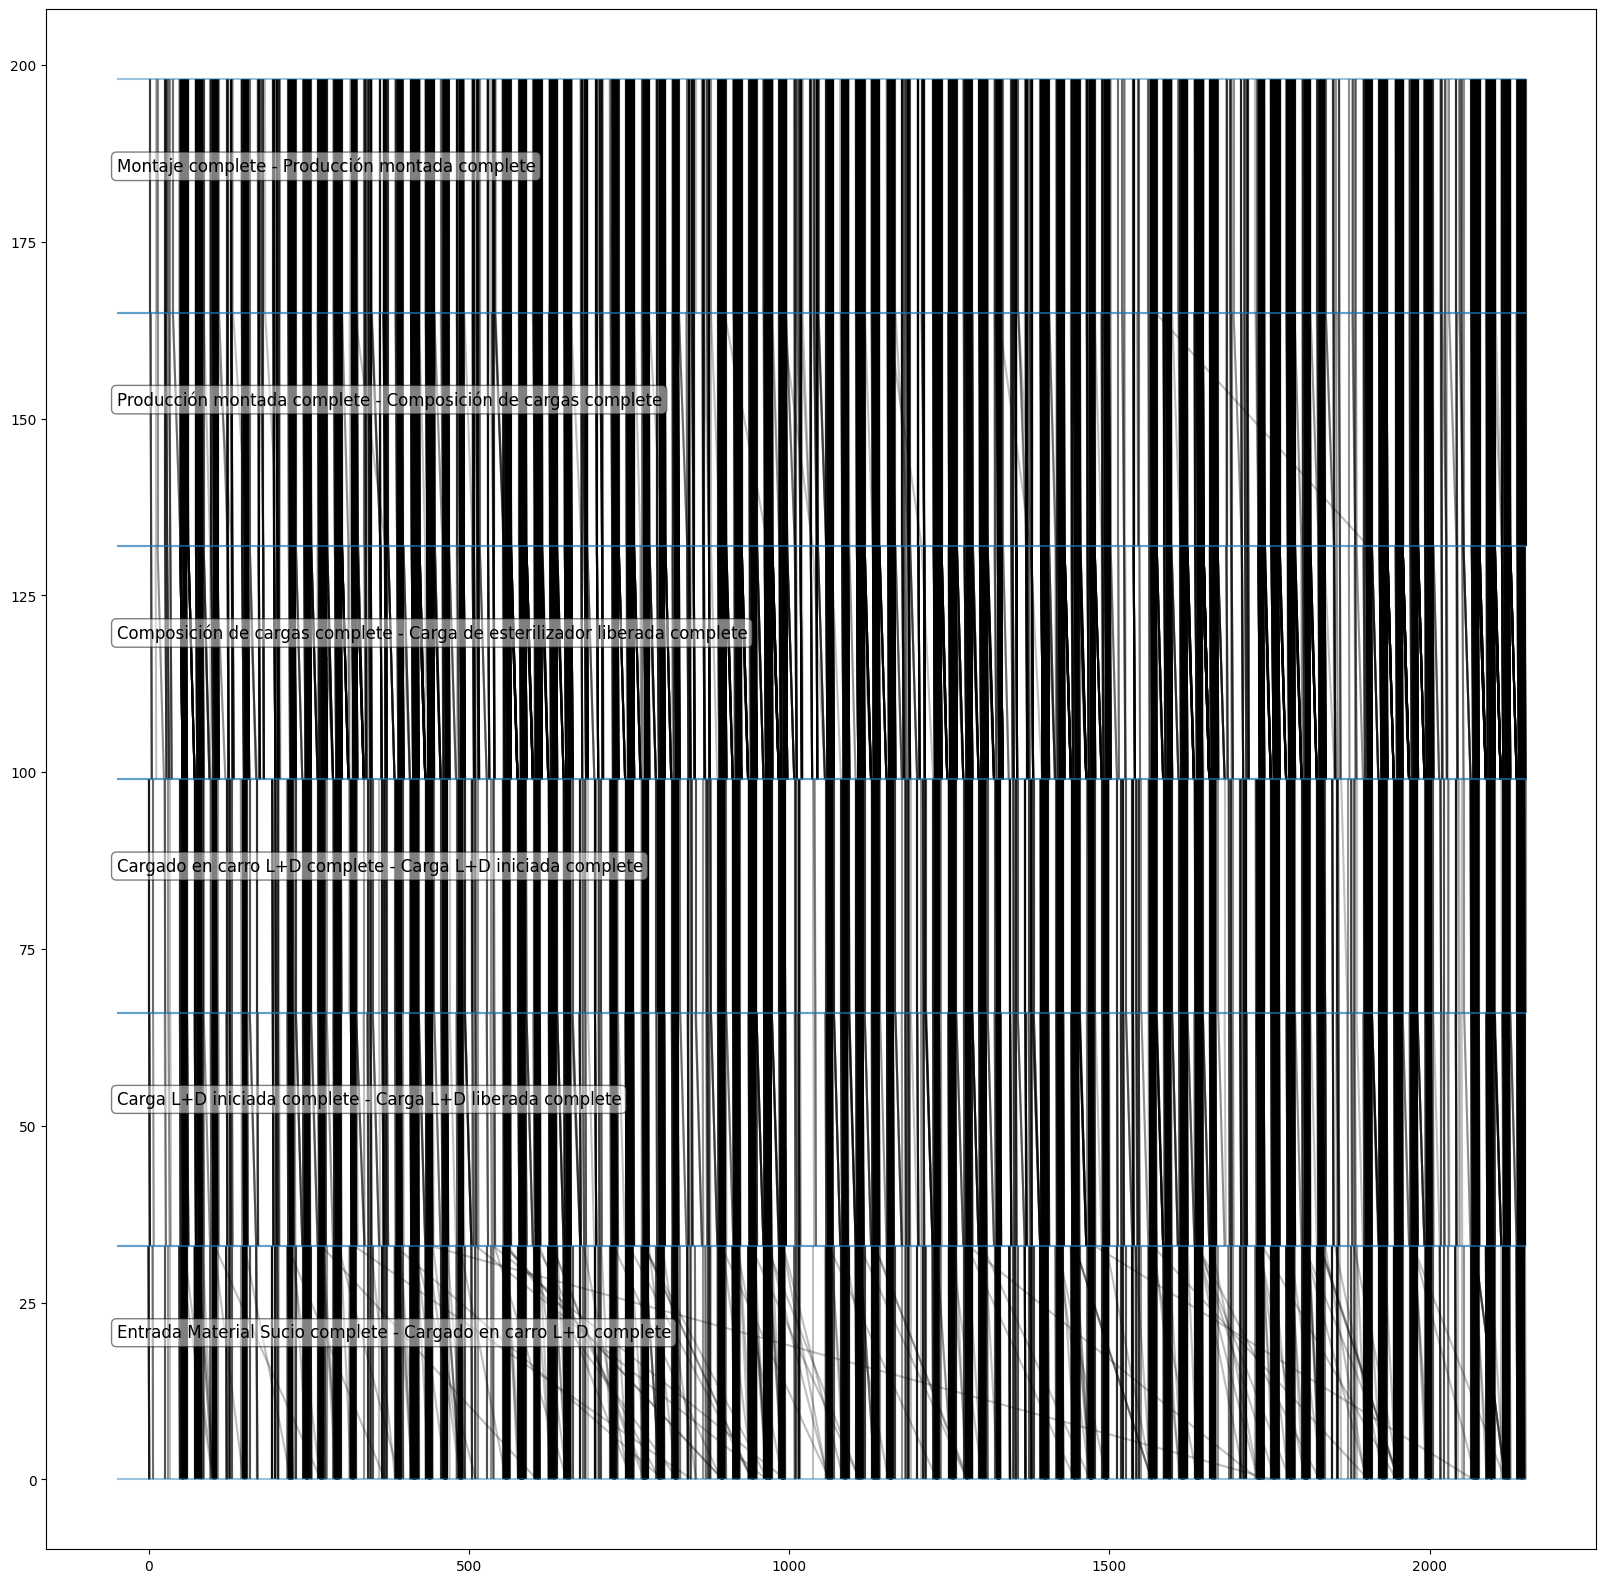

In [36]:
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(0,0,0),(1,0,0)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is the provided mask, False gives first color (black) True gives second color (red)
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, mask=vis_rf.pf['start_time'] > 10000, vis_mask=True)

#### 3- OG Performance Spectrum coloring based on classifier=hist

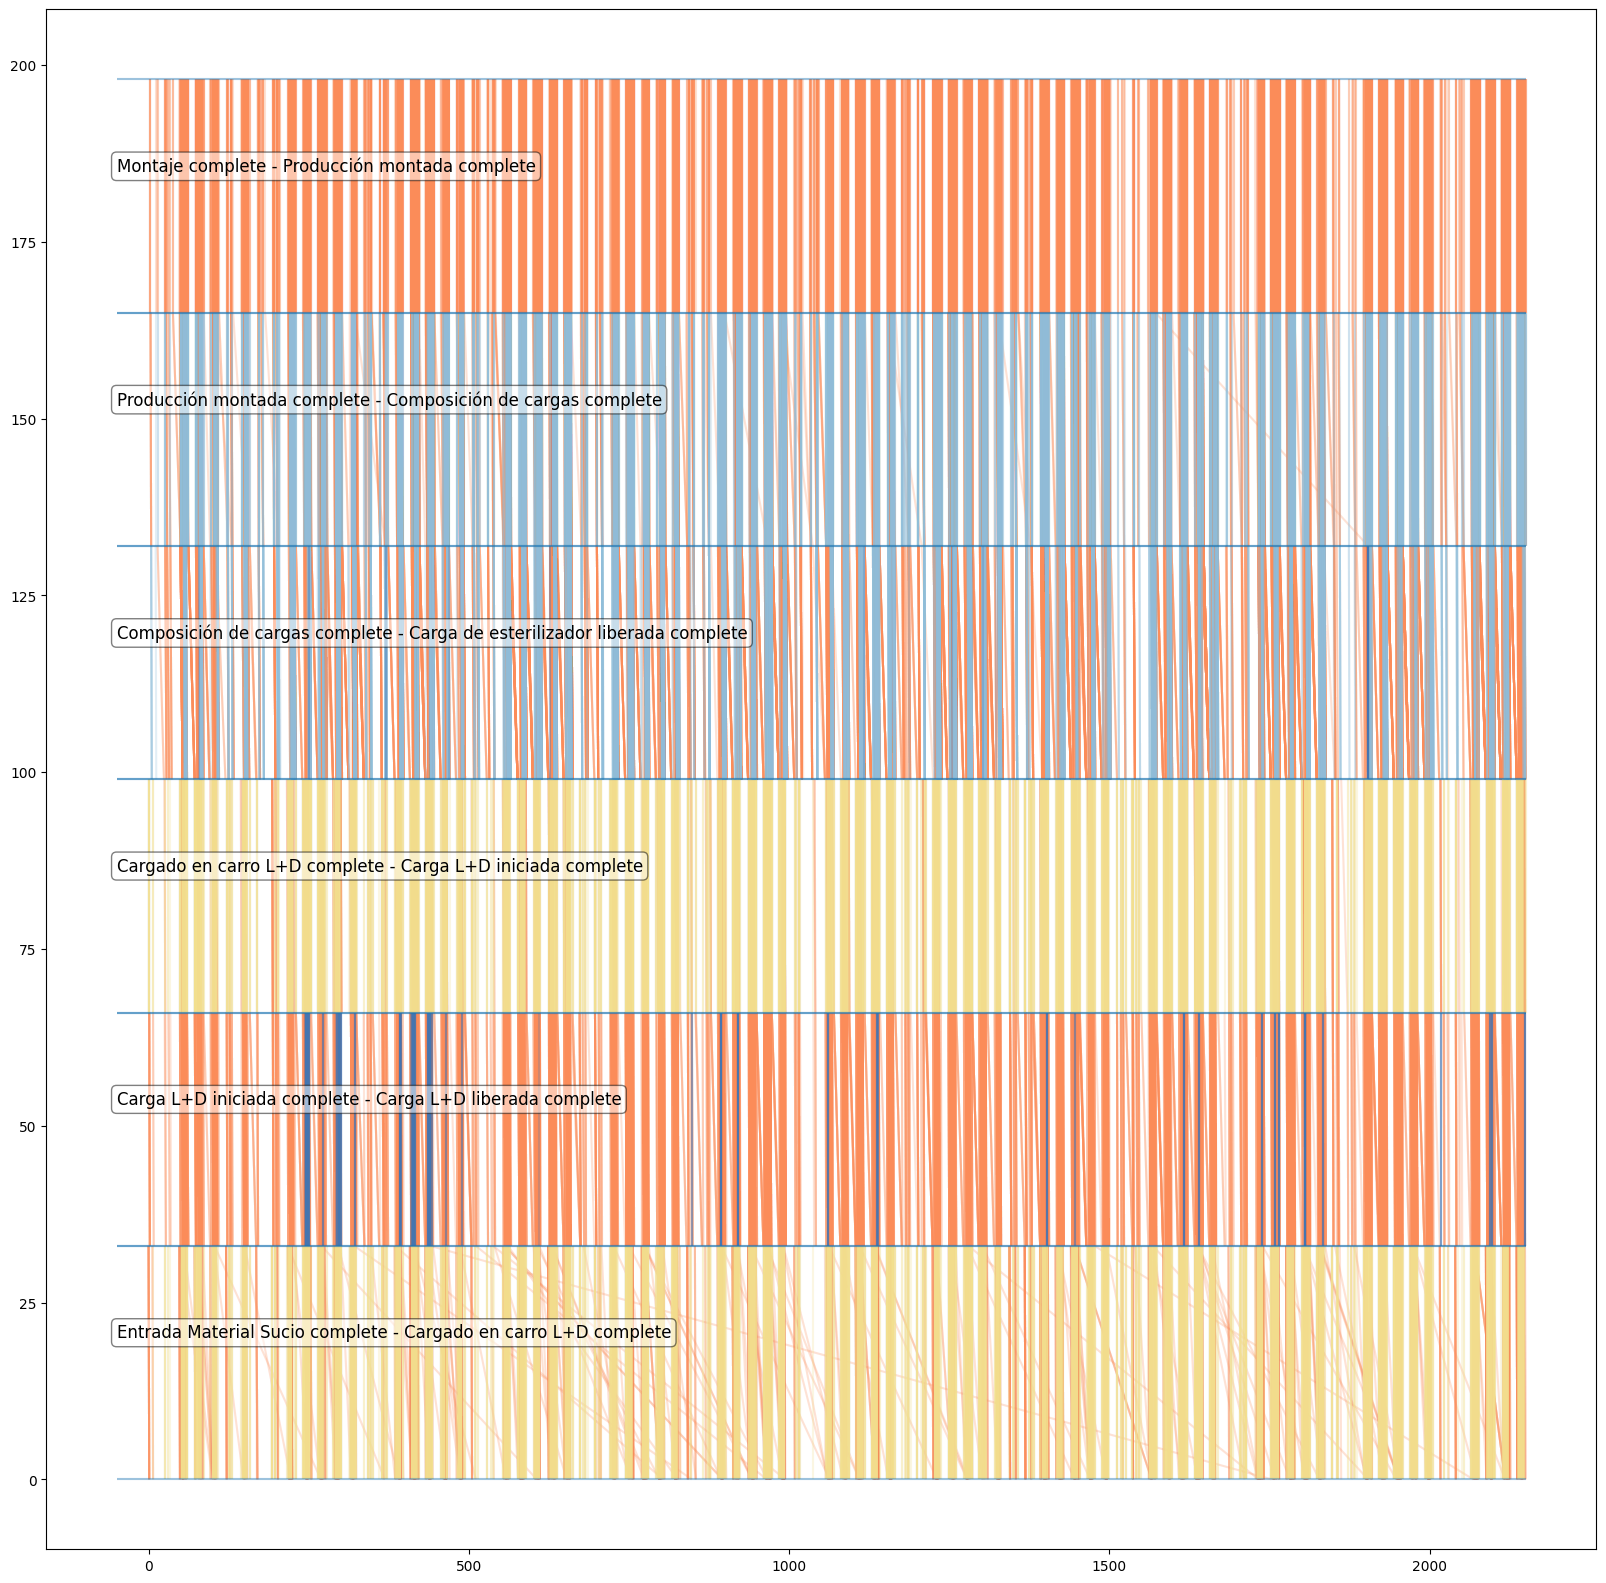

In [37]:
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance (4) quantiles color by `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

#### 4- Visualize a certain classes (0 and 1 in this example)

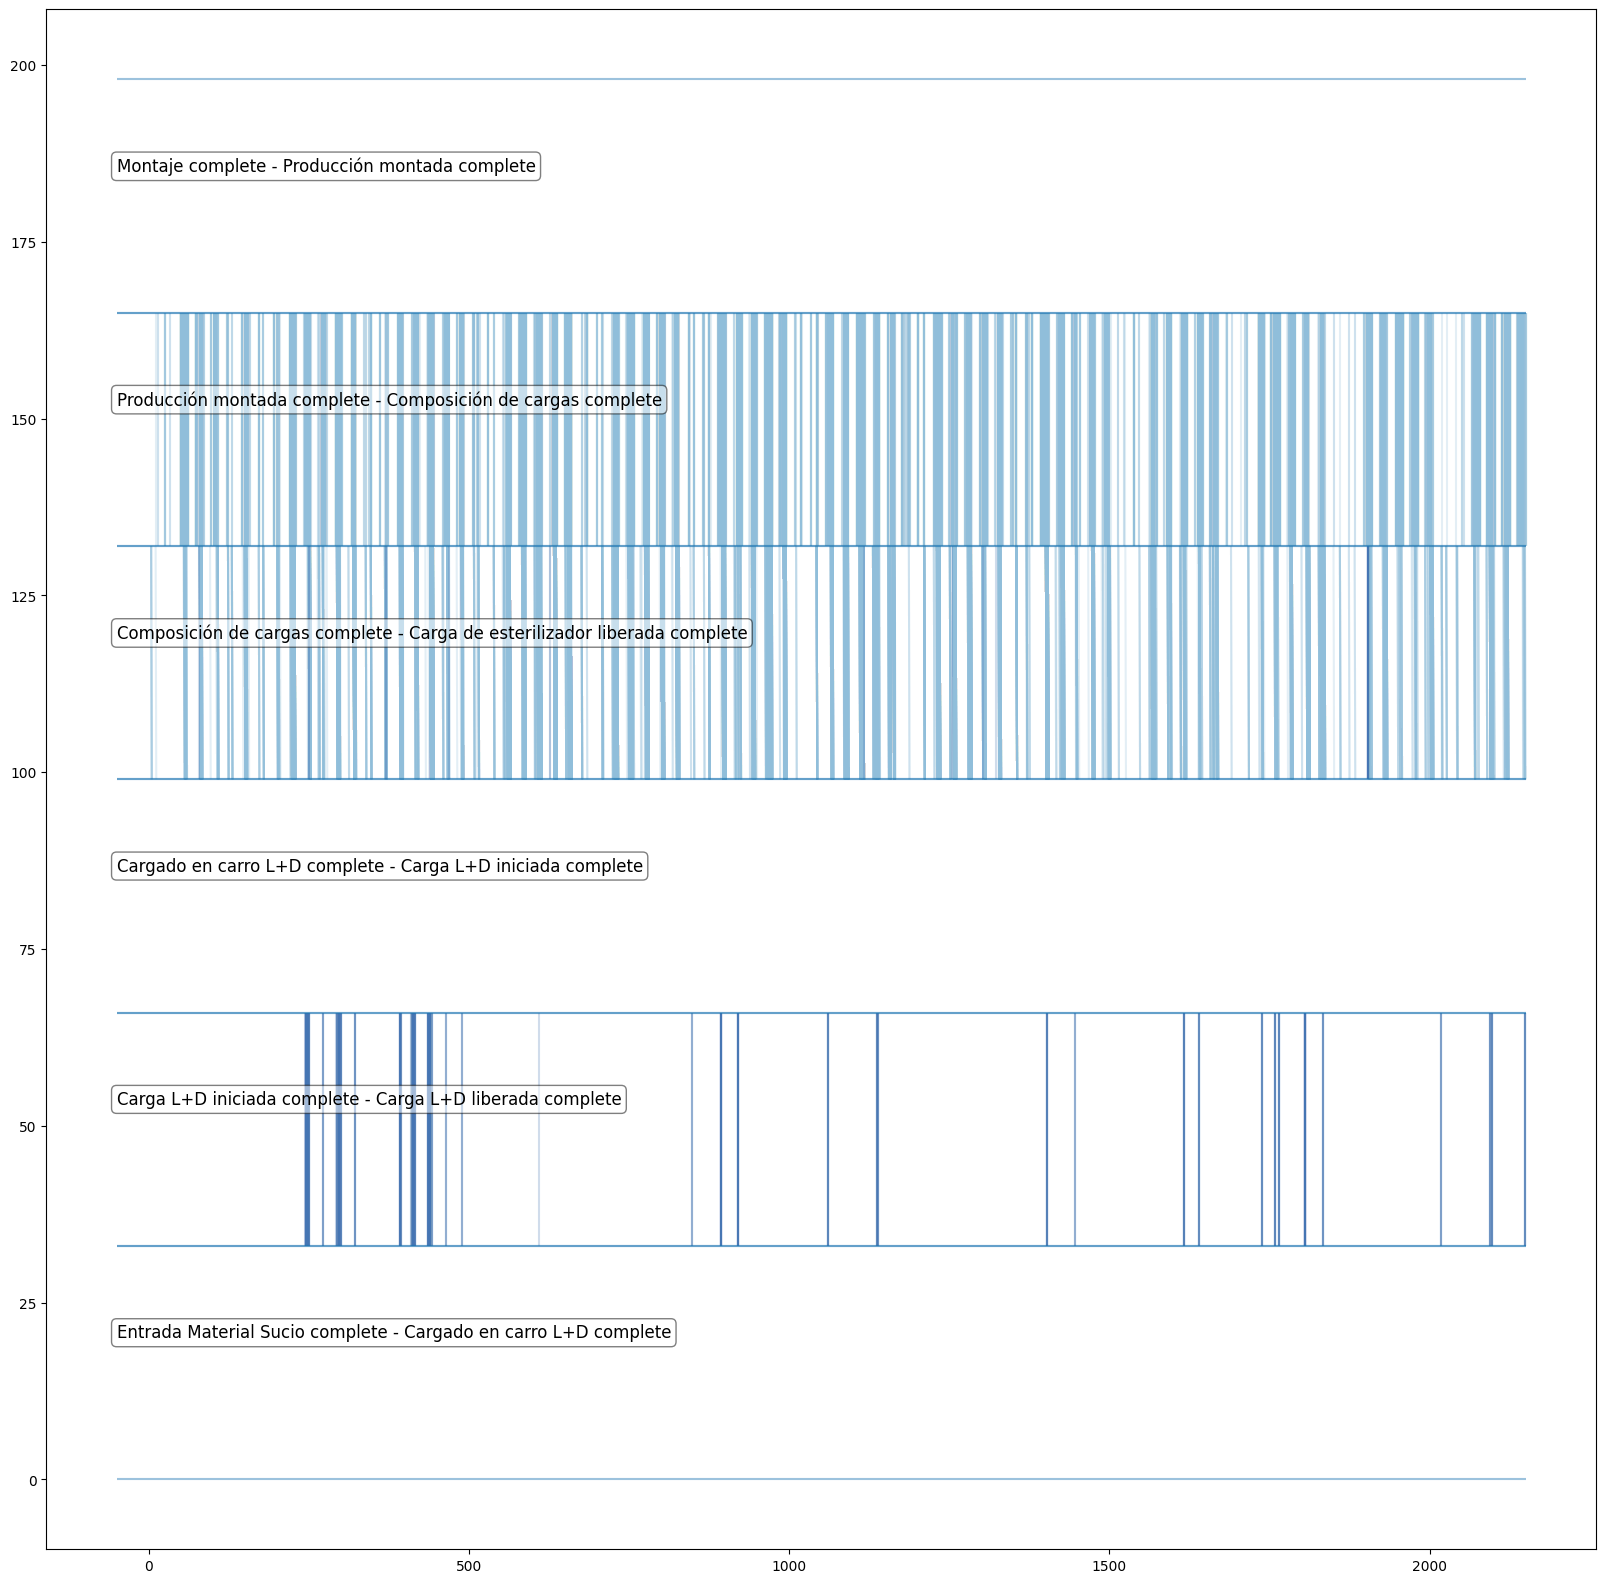

In [38]:
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance (4) quantiles color by `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, show_classes=[0,1], metric='duration', args=[4])

### Visualize our data
#### Use Dataframe Masks to Filter Events Before Computing Segments

In [39]:
# reload our event data (we keep more metadata this time)
rf.load_frame(maxdate=datetime.datetime(2023, 4, 1, 0, 0))
rf.create_structure()
# each segment has 2 activities, we can keep the meta data of both the start and end activity for a specific column like this:
rf.remove_meta()

> Creating Pandas DataFrame from event log, this might take a while...
> Done, continue with inspection of pf and create_structure
> Shifting log to generate case transitions.
> Adjusting time-grain to seconds.
> Done, continue with remove_meta to remove columns from pf and to correct naming.


In [43]:
rf.pf.head()

case_id start_org:resource end_org:resource  start_time  end_time  \
0      0.0                 LI               LI      1254.0    1254.0   
1      0.0                 LI               MR      1254.0    1255.0   
2      0.0                 MR               SM      1255.0    1256.0   
4      1.0                 PG               PG      1302.0    1302.0   
5      1.0                 PG               EH      1302.0    1302.0   

                                        segment_name  duration  segment_index  
0  Entrada Material Sucio complete - Cargado en c...       0.0              0  
1  Cargado en carro L+D complete - Carga L+D inic...       1.0              1  
2  Carga L+D iniciada complete - Carga L+D libera...       1.0              2  
4  Entrada Material Sucio complete - Cargado en c...       0.0              0  
5  Cargado en carro L+D complete - Carga L+D inic...       0.0              1

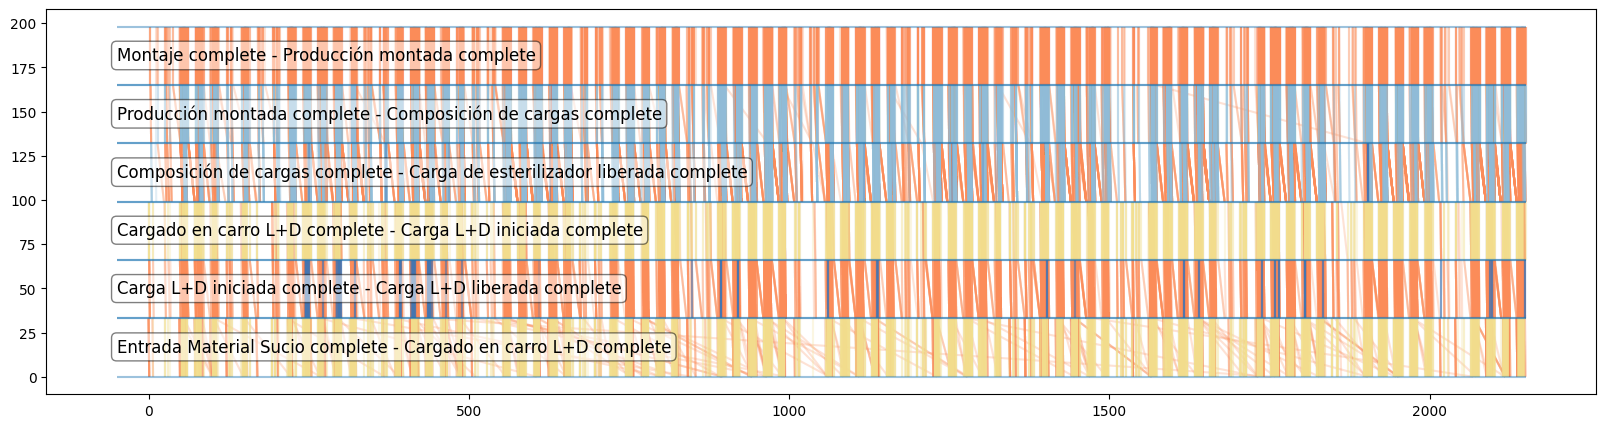

In [44]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,5])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

#### Visualize data based on the staring activity

In [ ]:
# reload our earlier event data
rf = Performance_Spectrum.load_log('croma')

In [58]:
import re
# get the 6 most frequent segments
segments = list(rf.segment_counts().keys())
# but filter out any "Appeal"-related activities, i.e., the events are removed from the data
# the segments in the performance spectrum then "jump over" all "Appeal"-related activities

segments_entrada_material_sucio = [s for s in segments if "Entrada Material Sucio complete -" in s]
segments_cargado_en_carro_ld = [s for s in segments if "Cargado en carro L+D complete -" in s]
segments_carga_ld_iniciada = [s for s in segments if "Carga L+D iniciada complete -" in s]
segments_carga_ld_liberada = [s for s in segments if "Carga L+D liberada complete -" in s]
segments_montaje = [s for s in segments if "Montaje complete -" in s]
segments_produccion_montada = [s for s in segments if "Producción montada complete -" in s]
segments_composición_de_cargas = [s for s in segments if "Composición de cargas complete -" in s]
segments_carga_de_esterilizador_liberada = [s for s in segments if "Carga de esterilizador liberada complete -" in s]
segments_comisionado = [s for s in segments if "Comisionado complete -" in s]



##### 1- Starting with Entrada Material Sucio

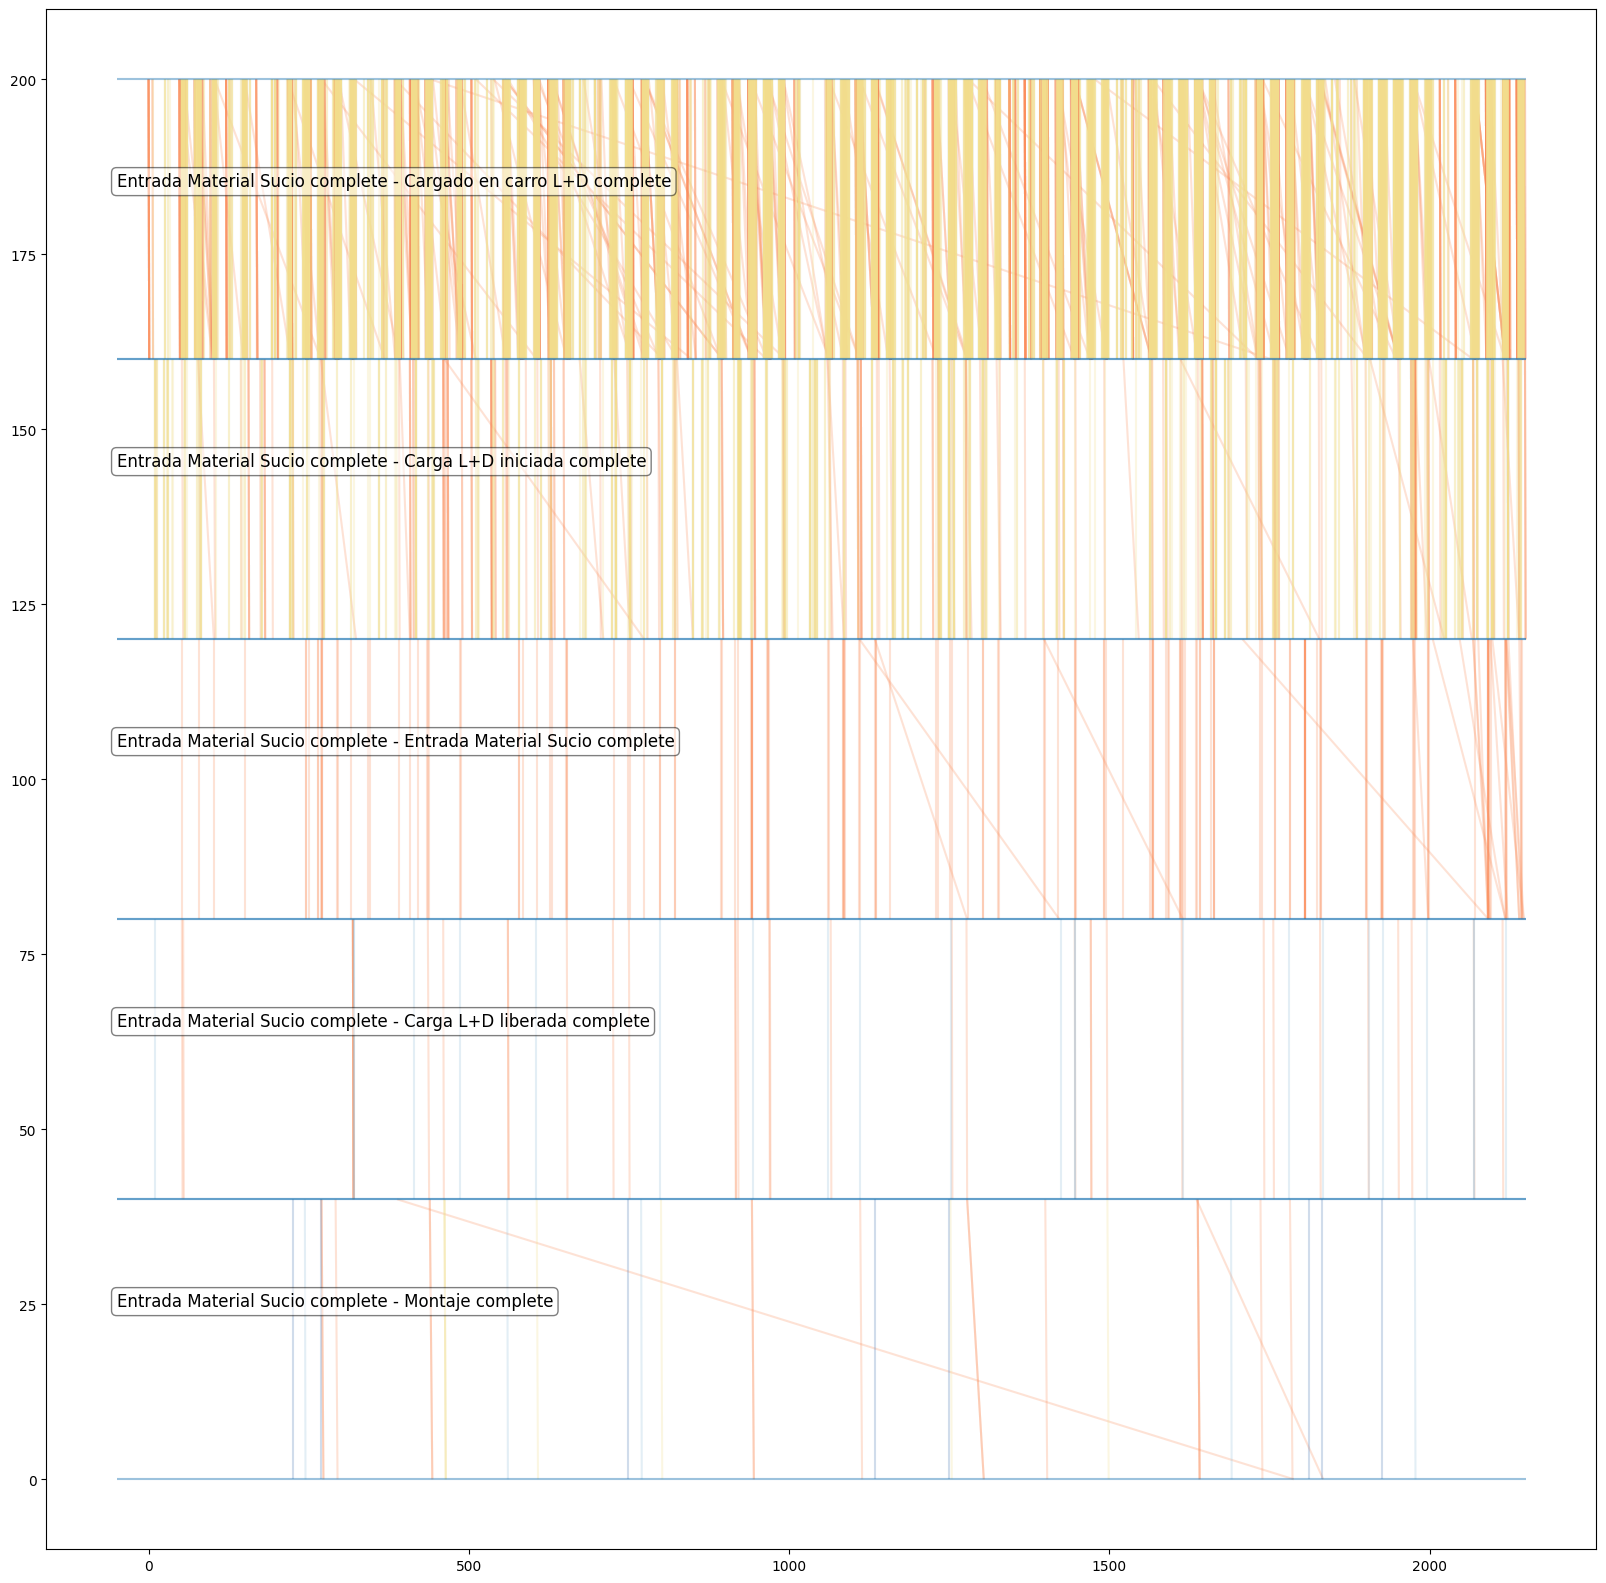

In [59]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_entrada_material_sucio, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

##### 2- Starting with Cargado en carro L+D

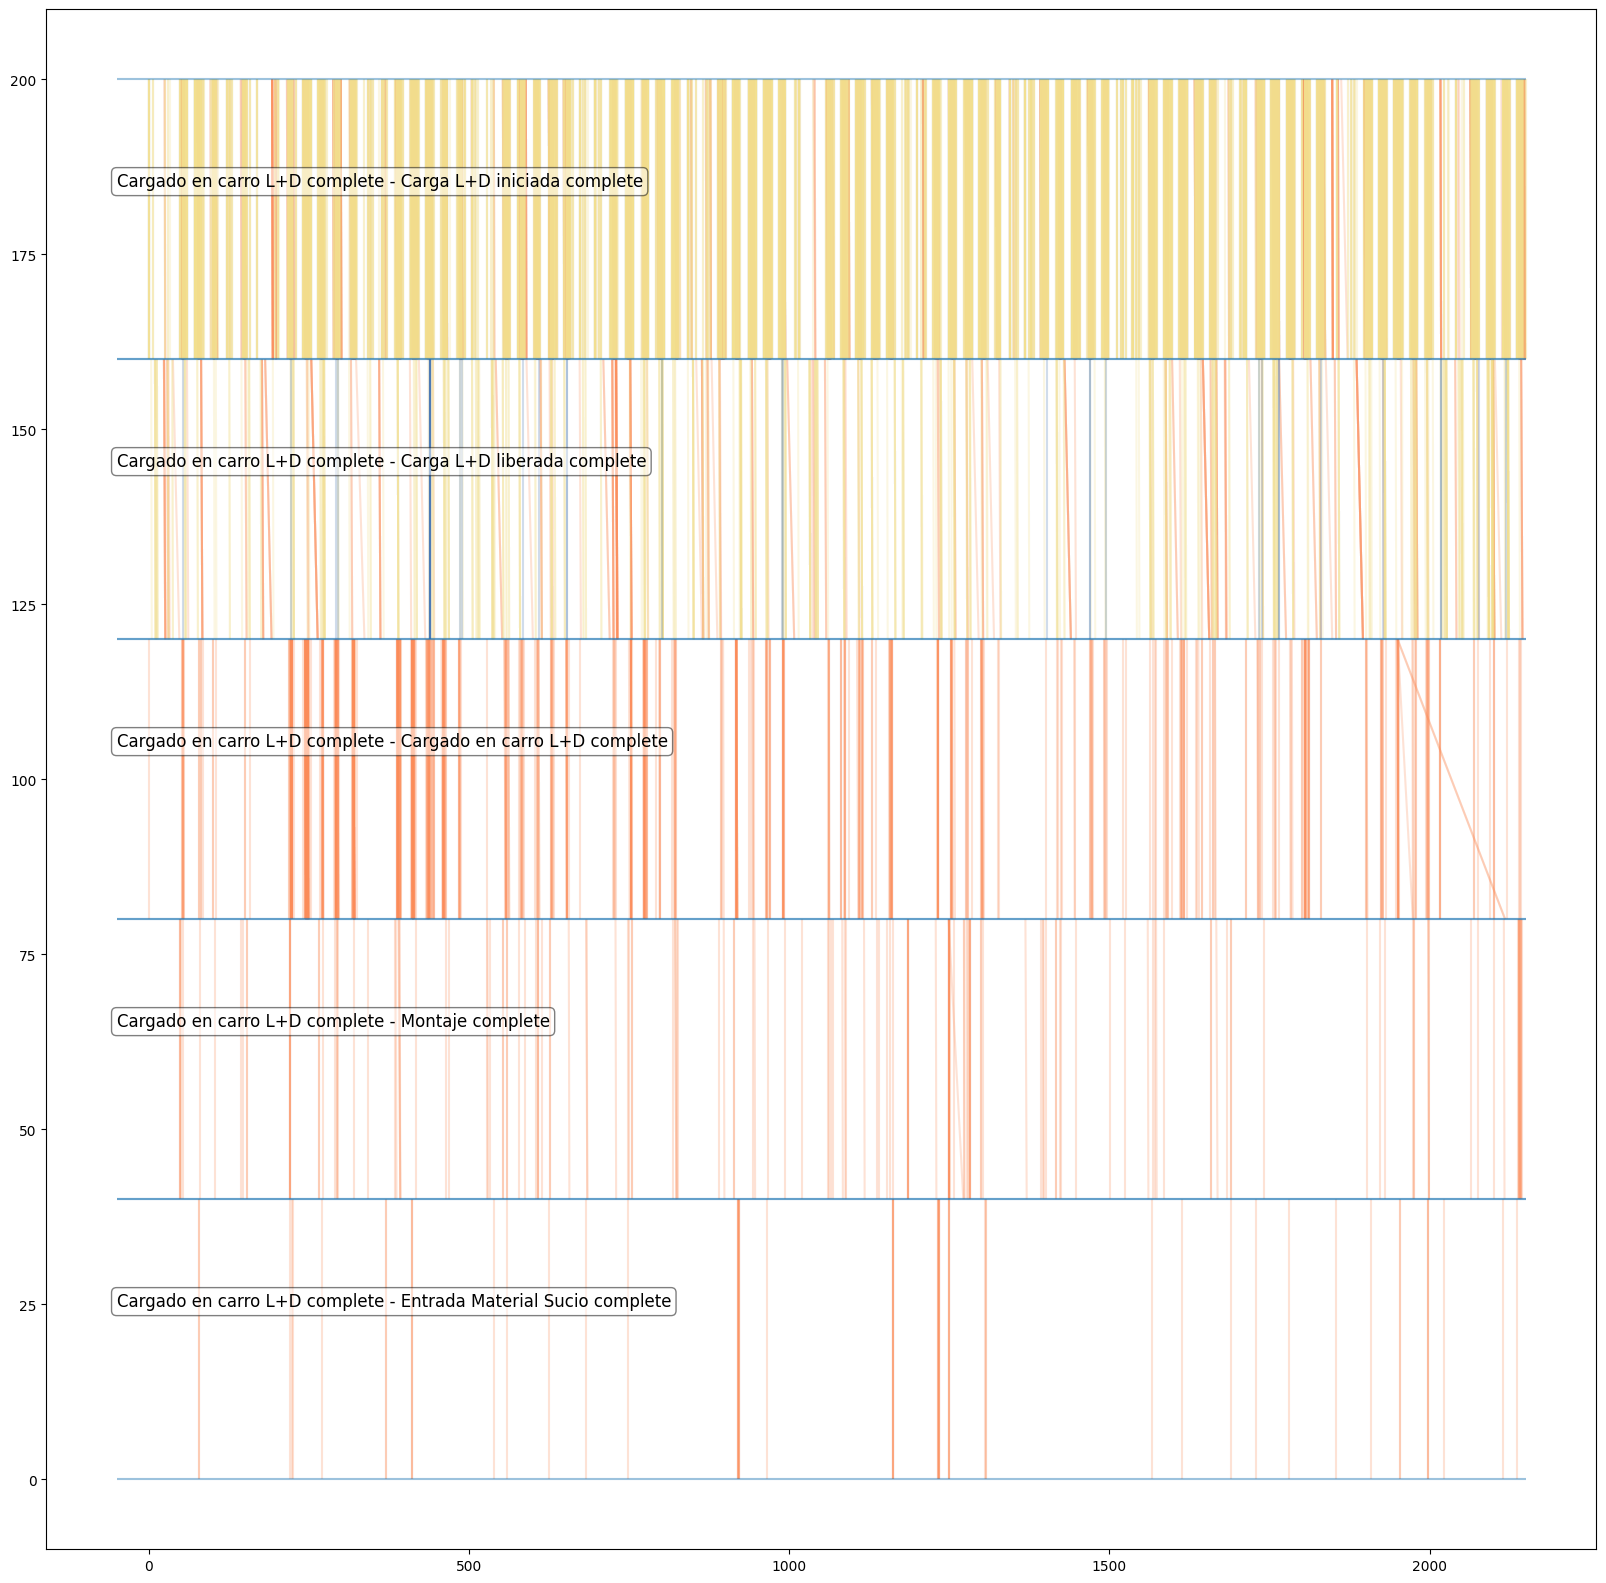

In [60]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_cargado_en_carro_ld, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

##### 3- Starting with Carga L+D iniciada

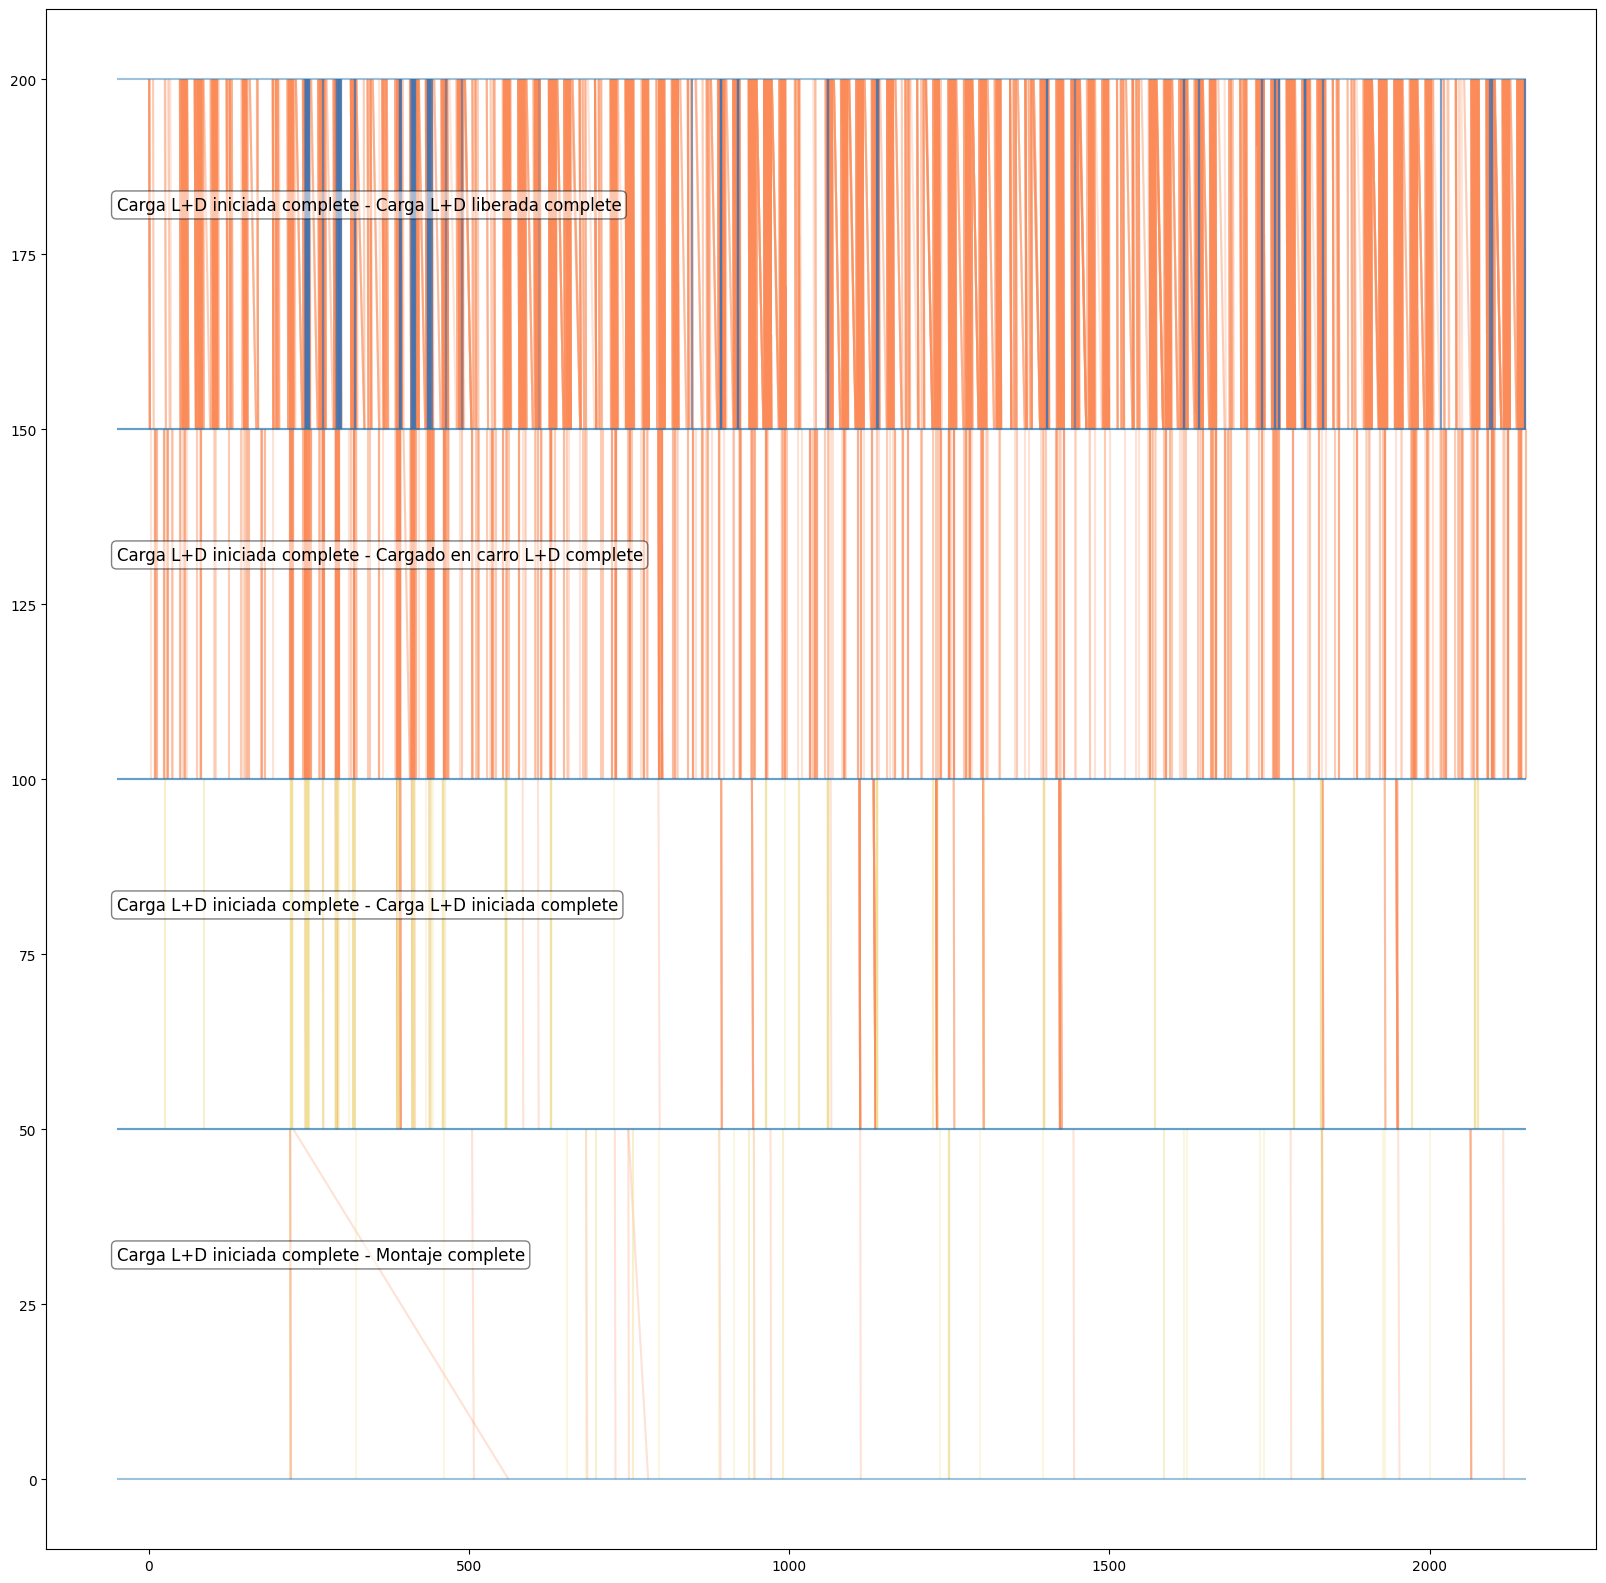

In [61]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_carga_ld_iniciada, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

##### 4- Starting with Carga L+D liberada

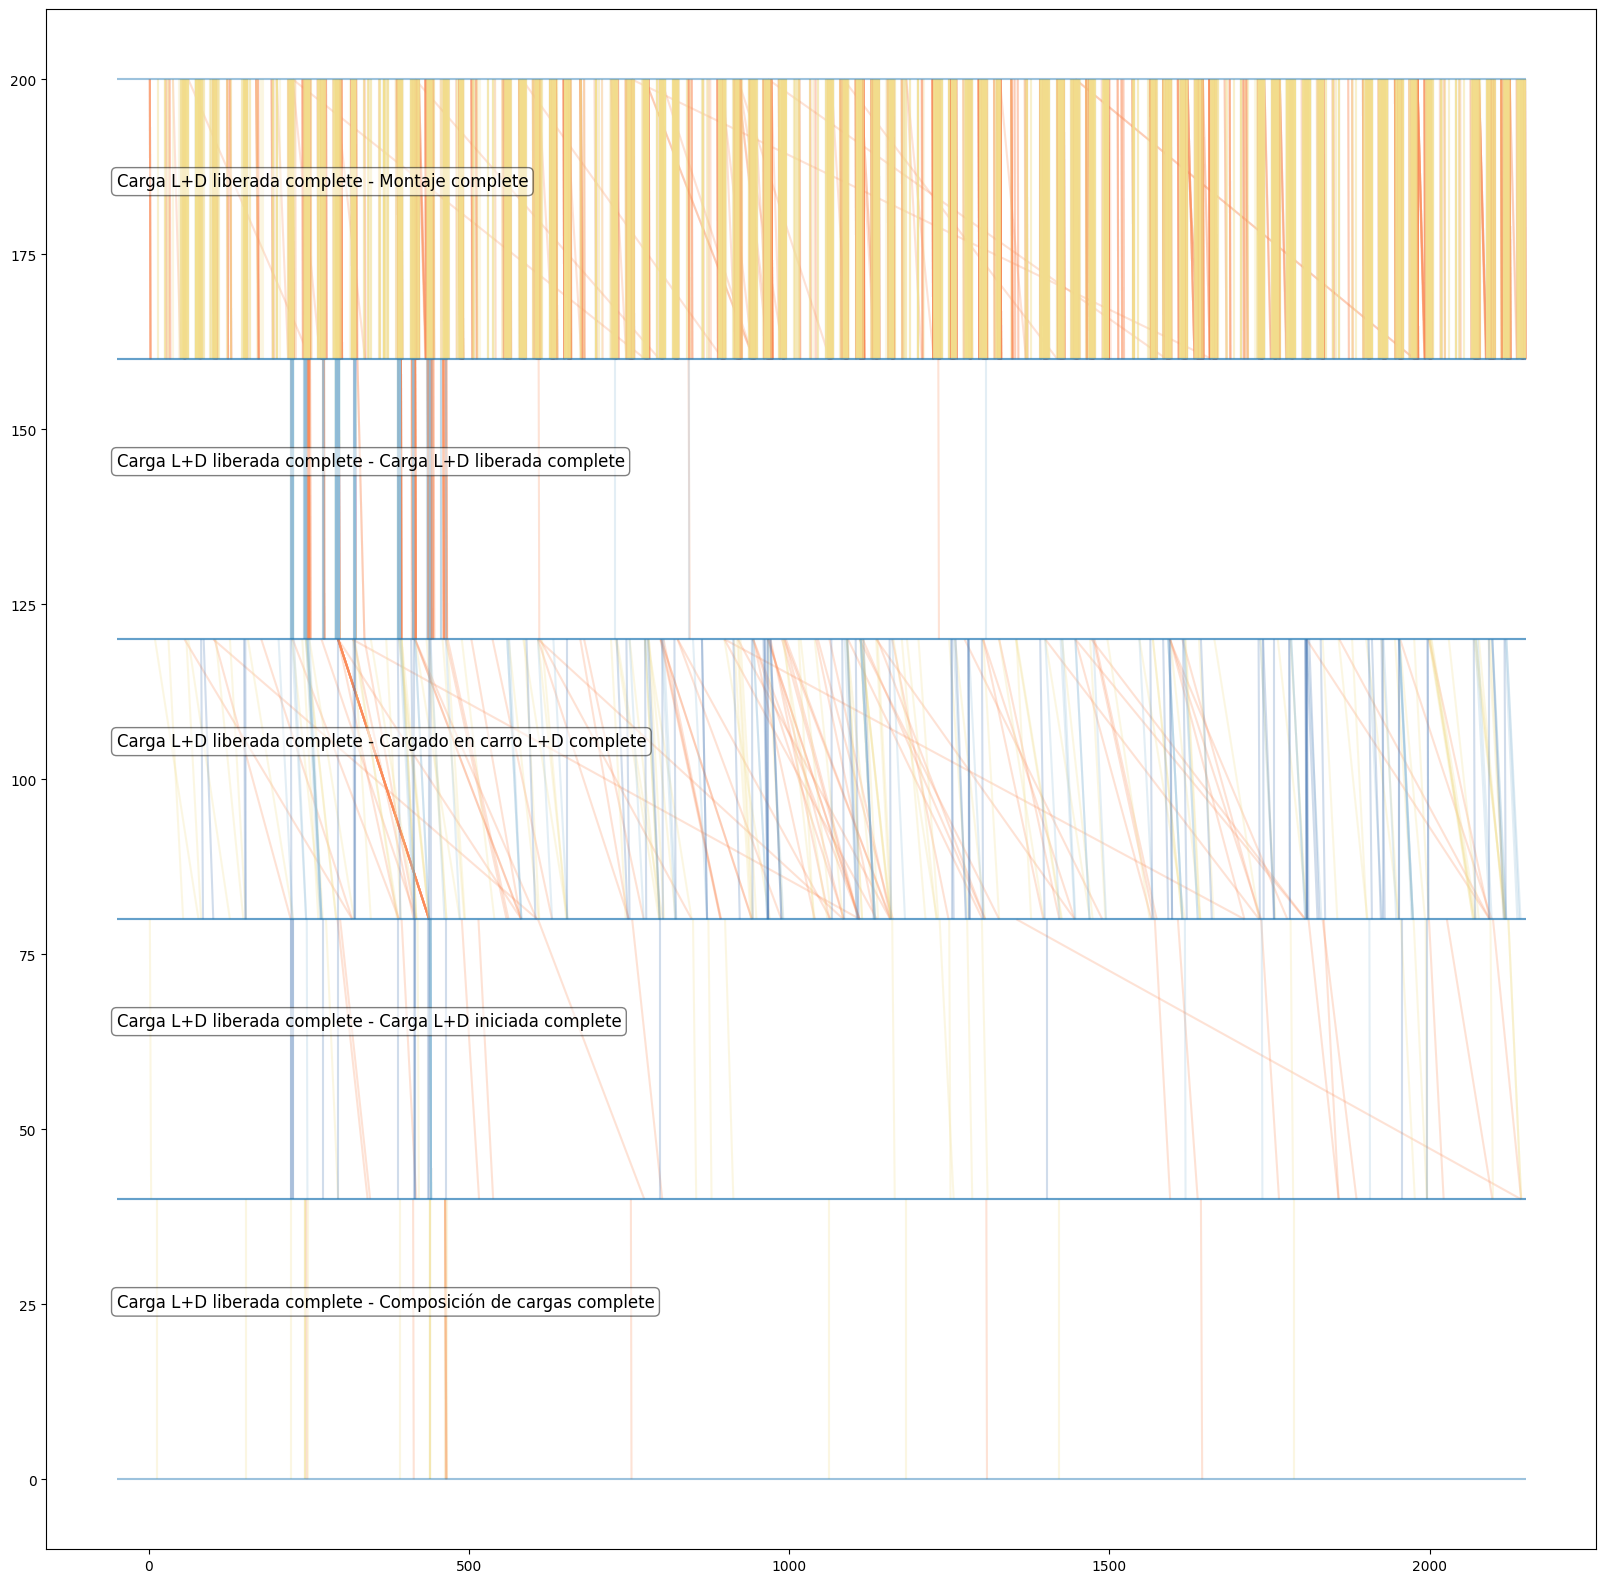

In [62]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_carga_ld_liberada, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

##### 5- Starting with Montaje

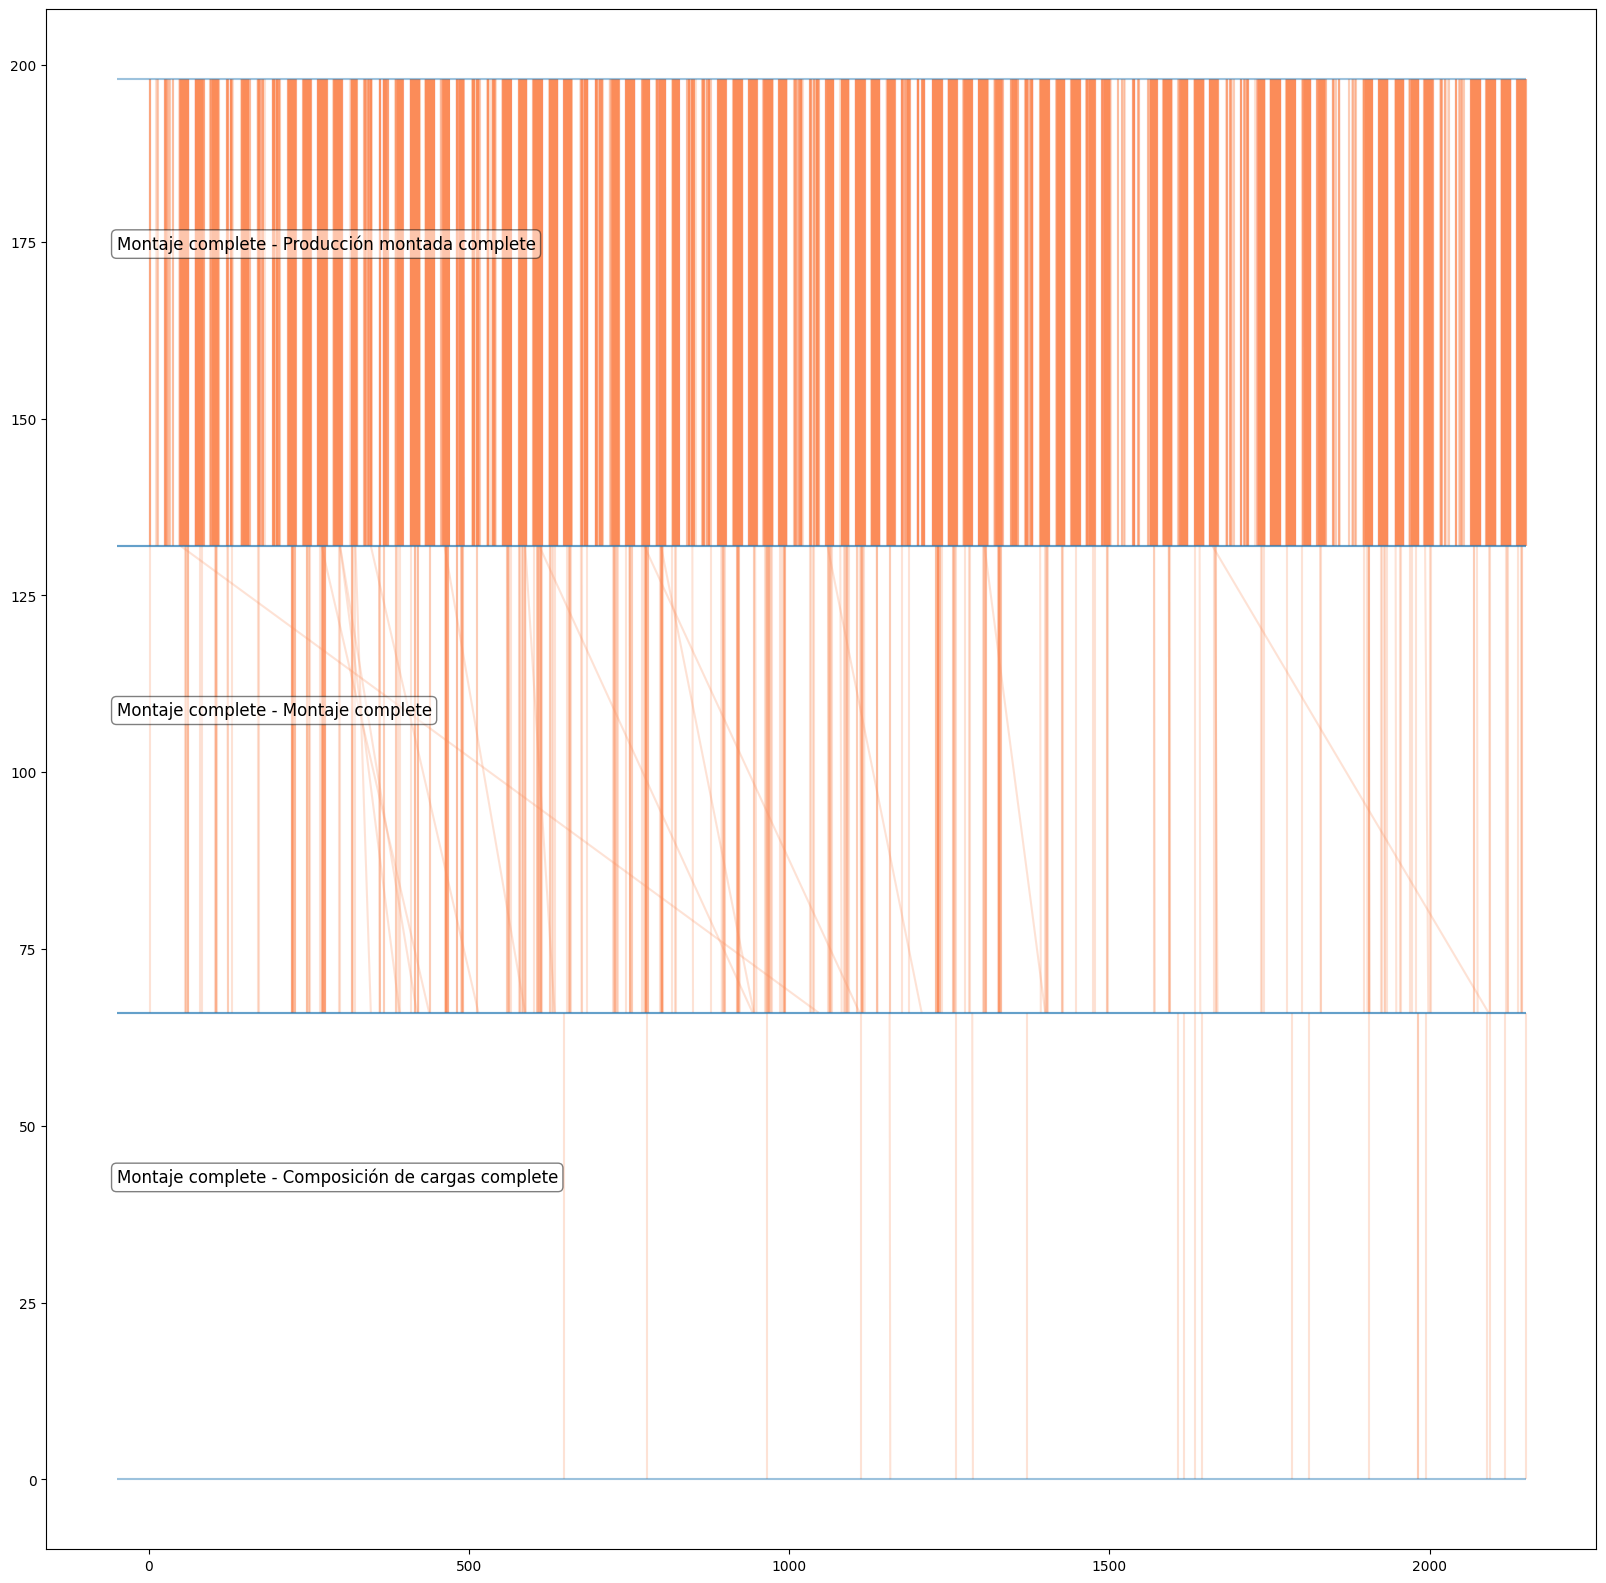

In [63]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_montaje, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

##### 6- Starting with Producción montada

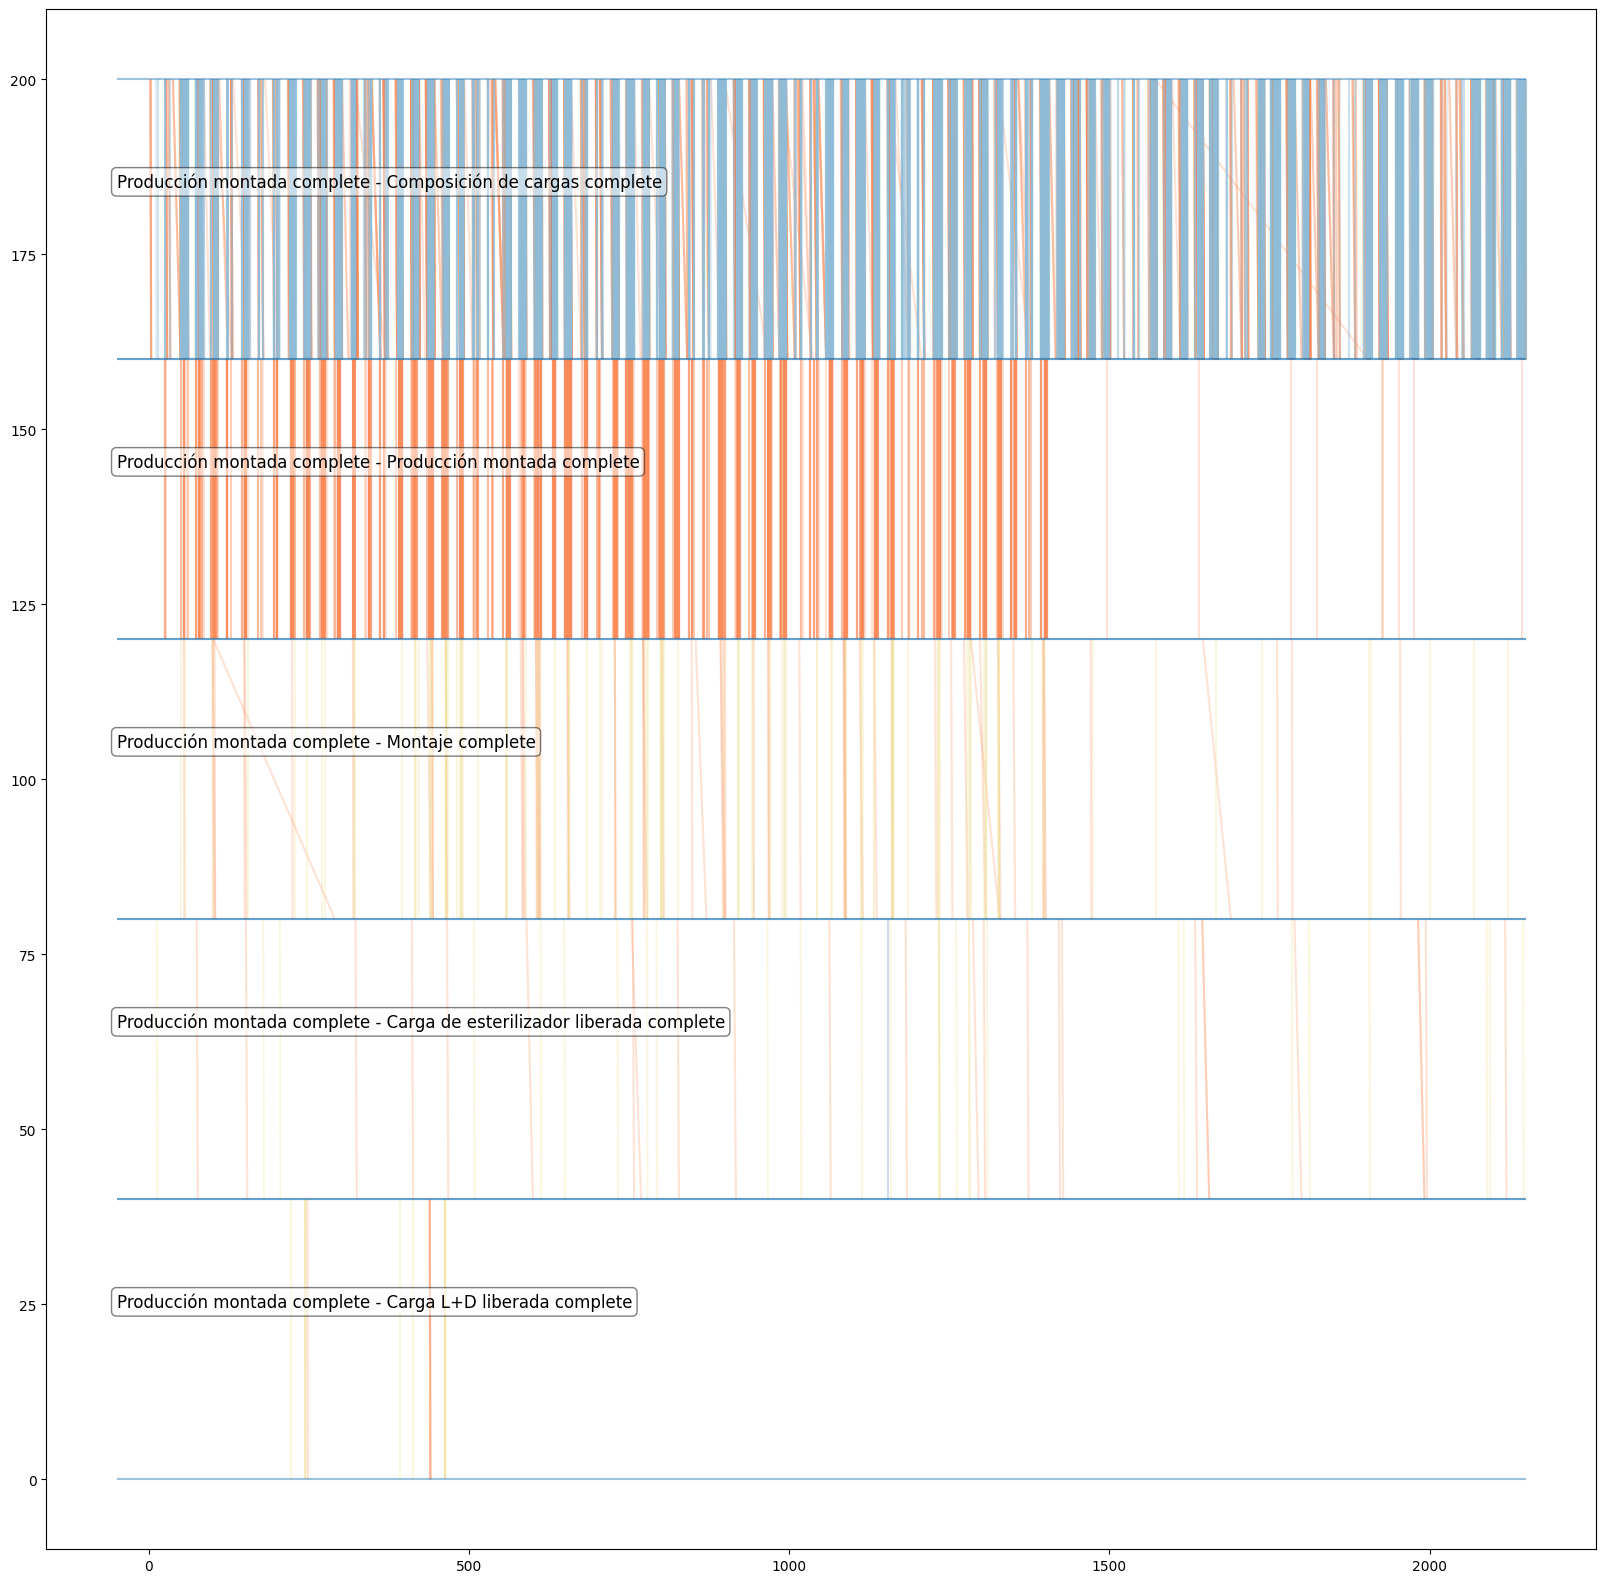

In [64]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_produccion_montada, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

##### 7- Starting with Composición de cargas

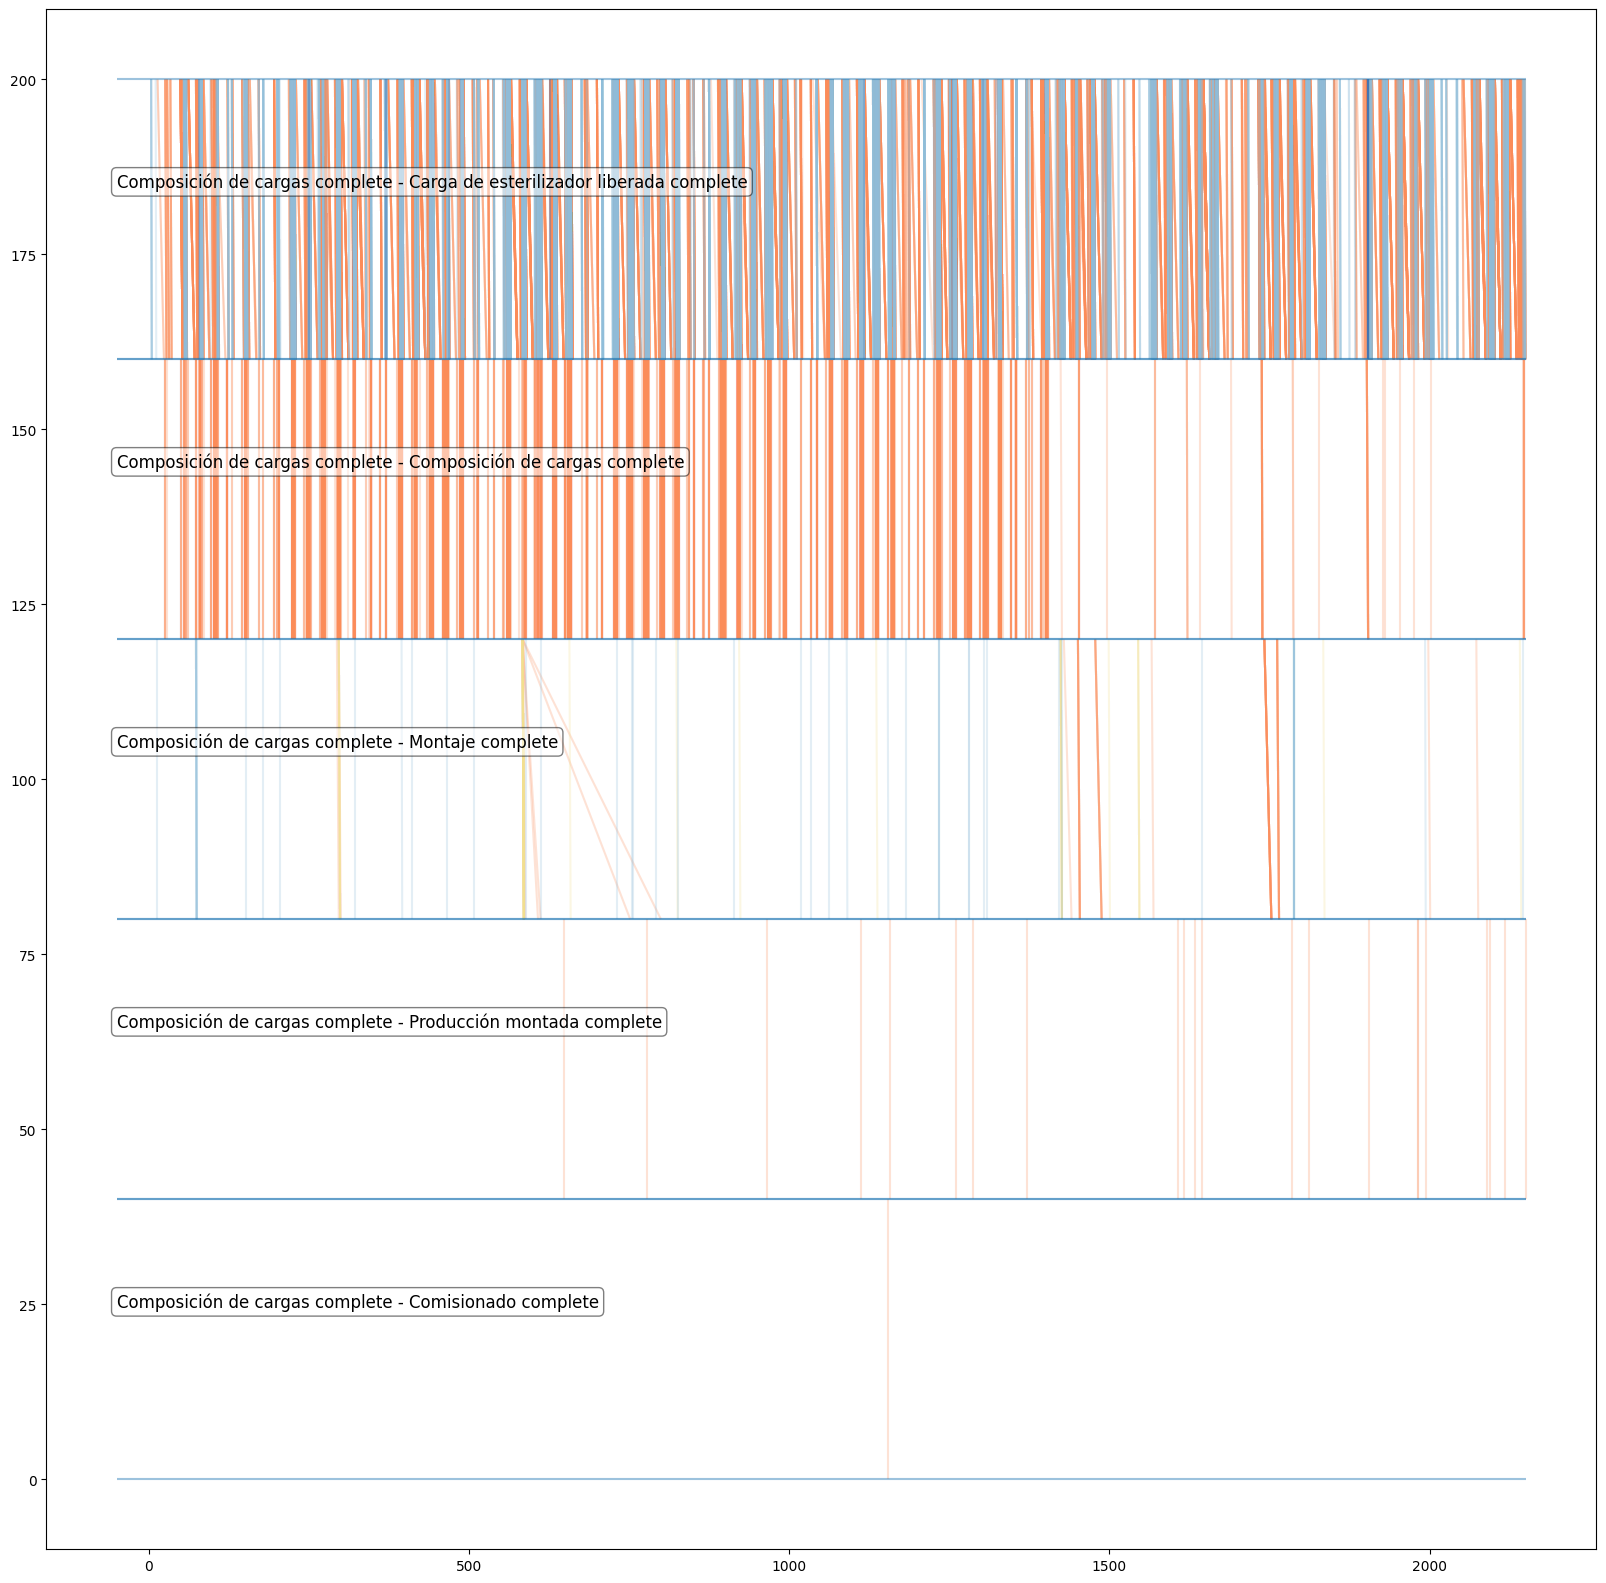

In [65]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_composición_de_cargas, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

##### 8- Starting with Carga de esterilizador liberada

In [66]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_carga_de_esterilizador_liberada, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

##### 9- Starting with Comisionado

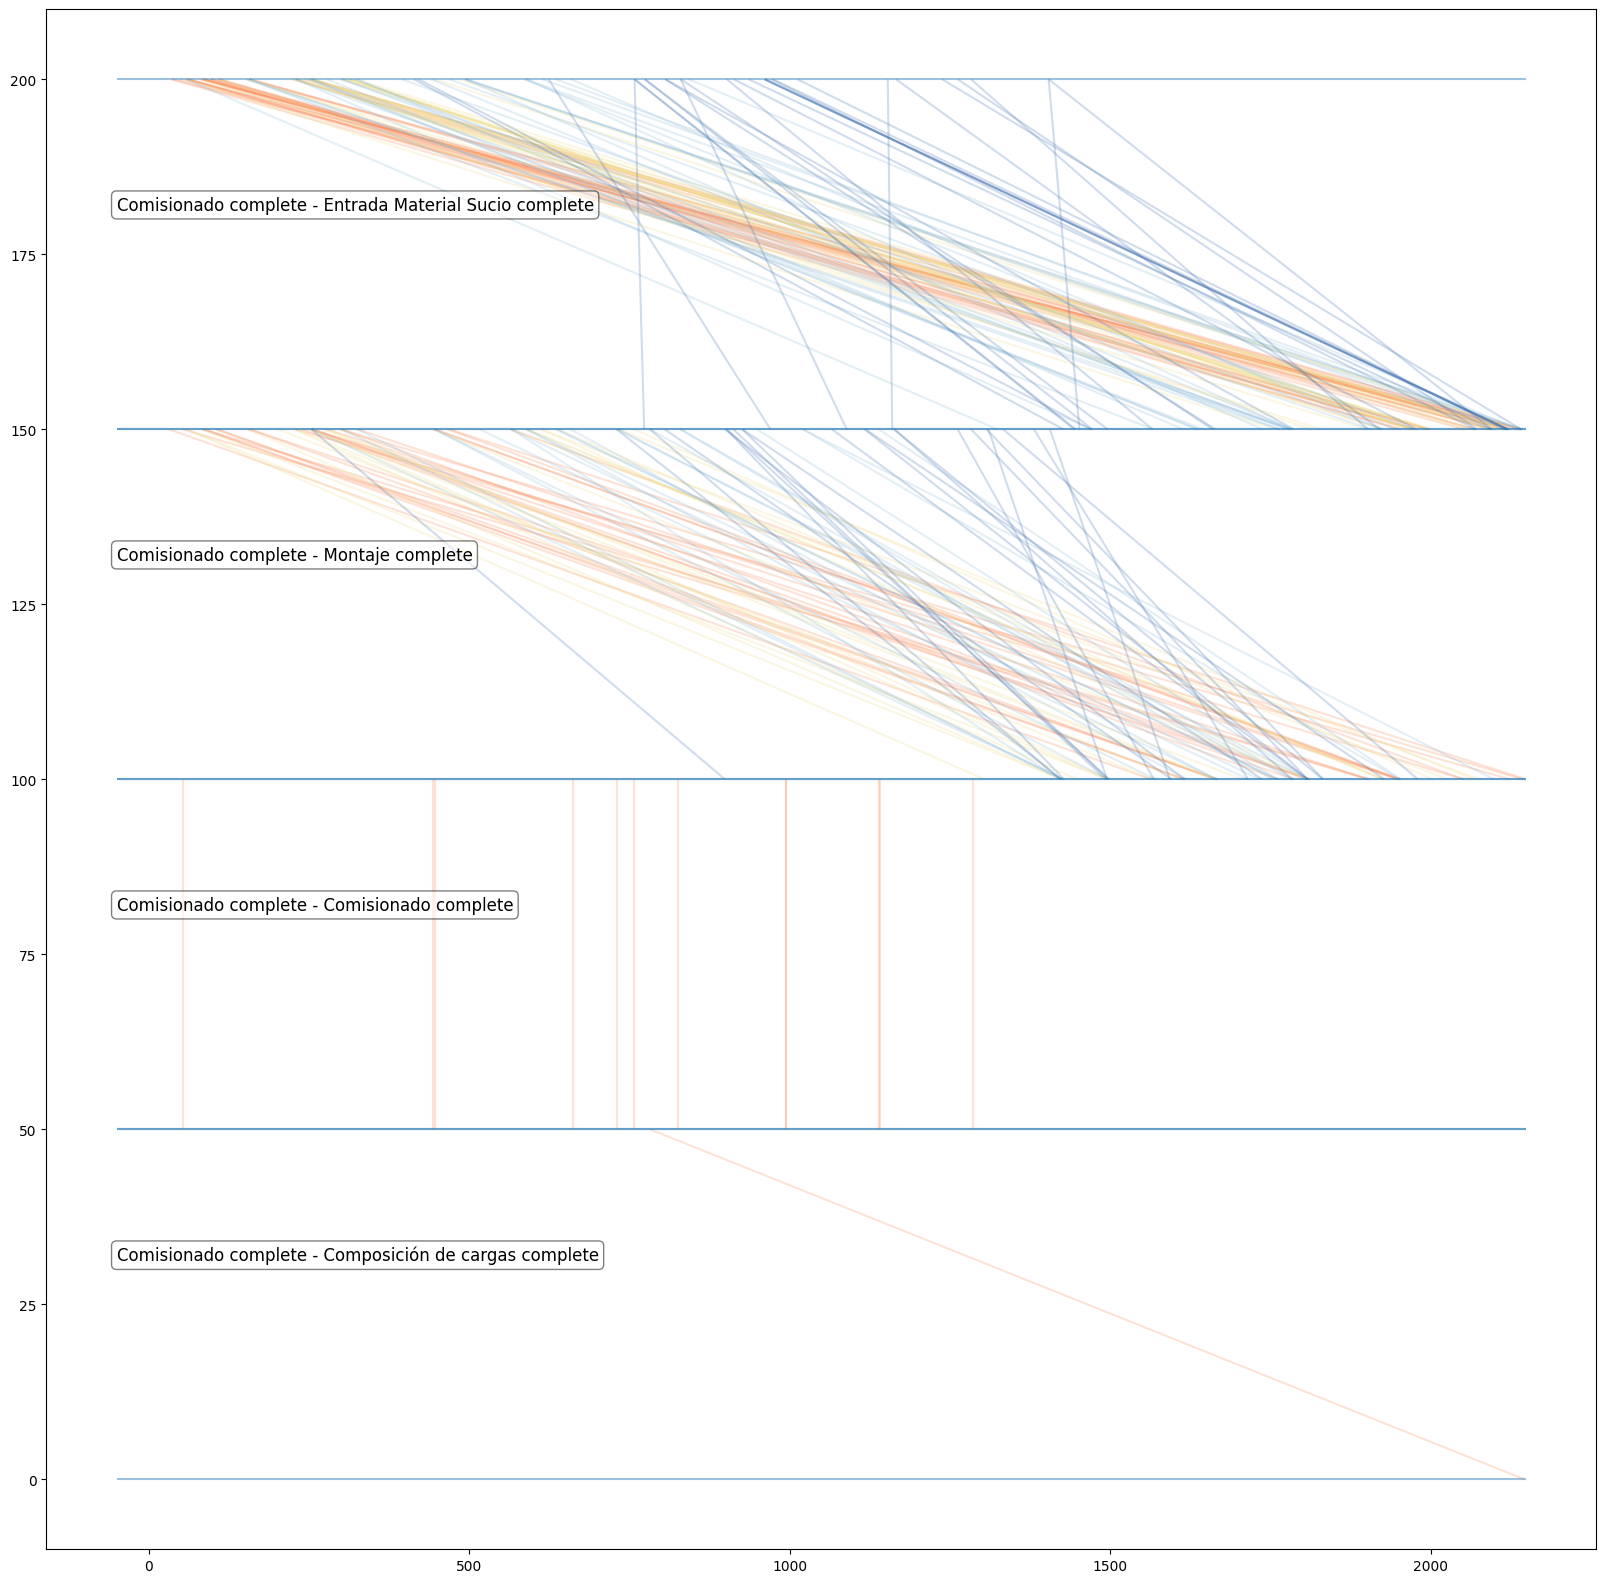

In [67]:
# compute the performance spectrum visualization
vis_rf = Performance_Spectrum.Spectrum(segments_comisionado, rf.pf)
# define colors for class-based coloring of lines as list of RGB values: (R/256,G/256/B256)
# for performance-based classes, length of list defines number of quantiles
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
# create plot
fig, ax = plt.subplots(figsize=[20,20])
# and visualize, classifier is histogram over 'duration' attribute into equi-distance quantiles based on `class_colors`
vis_rf.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_rf.classify_hist, metric='duration', args=[4])

### Infer Missing Start Times and Analyze Service Times
#### This Spectrum shows the estimated start for each activity and the difference between its starting and finishing time

In [68]:
# create new dataframe with start times inferred
pf_inferred = rf.infer_start_times()
# get all segment names
segments = pf_inferred['segment_name'].unique()
# and derive performance spectrum for
vis_inferred = Performance_Spectrum.Spectrum(segments, pf_inferred)

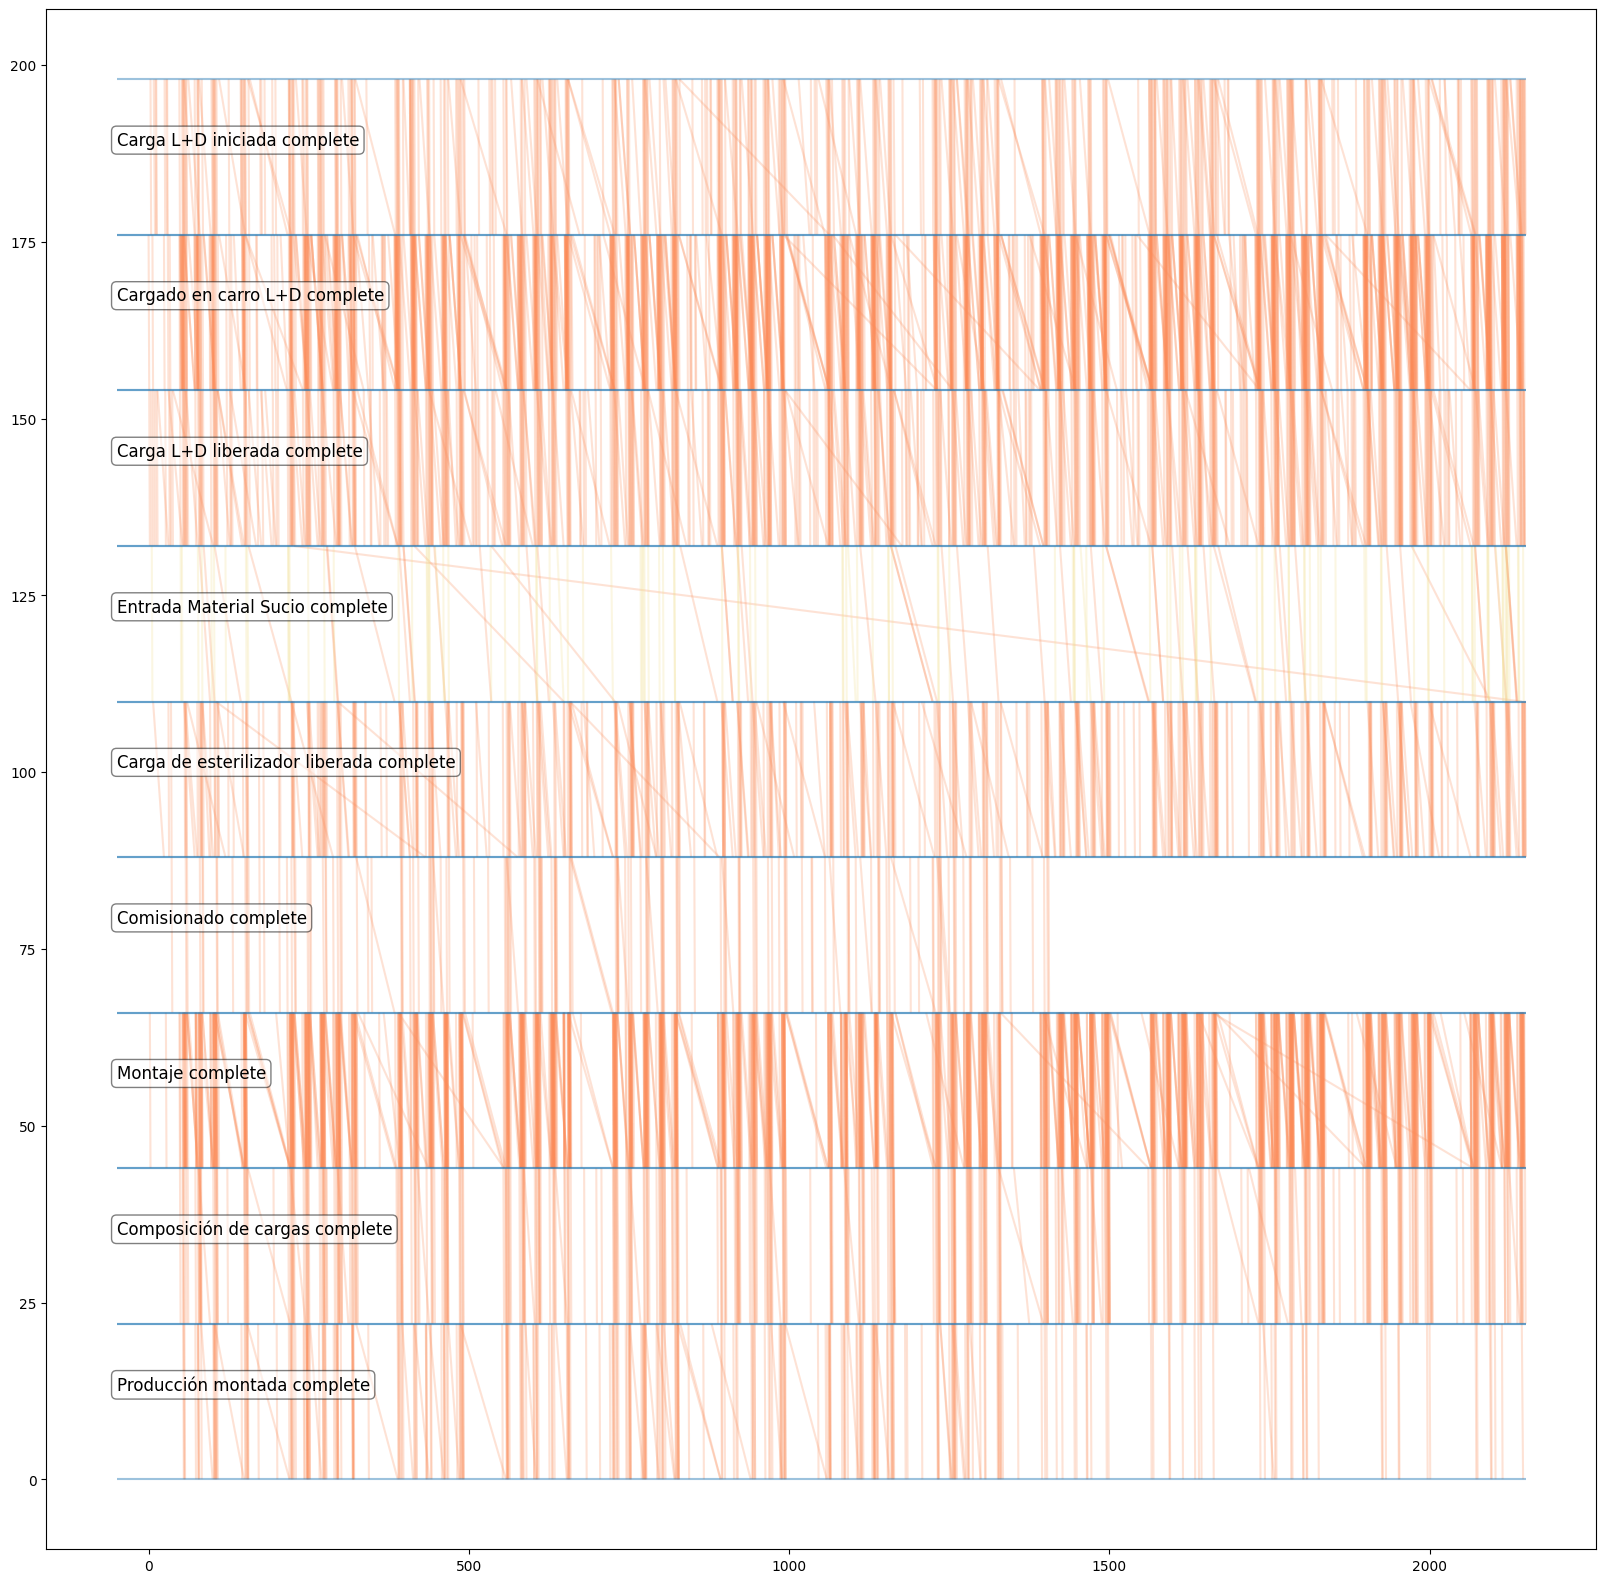

In [69]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256,89/256)]
fig, ax = plt.subplots(figsize=[20,20])
vis_inferred.plot_performance_spectrum(class_colors, ax, label_offset=-50, classifier=vis_inferred.classify_hist, metric='duration', args=[4])